# SARIMA forecast

## 01 - Background

Our goal in this challenge is to apply the basic concepts of time series analysis on one-dimension data (sales depending on the date).

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;
3. use an econometric approach to model the serie and be able to forecast it;
4. use machine learning to hack this modelization.

The dataset is loaded from [this url]( https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly_champagne_sales.csv). We provide you the code to read the csv from an url. 

## 02 - Load Data
Let's start by loading the time series of the challenge (data/monthly_champagne_sales.csv)

👉 Convert dataframe with datetime objects as index to make it look like this
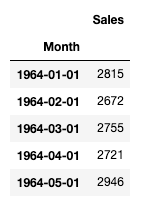

## 02 - Visualize and interpet the data

Well done, thanks to this "reindexing", you should now be able to plot the "Sales" (y-axis) as a function of the time (x-axis) easily

If your code is correct, you should be able to see that this Time Serie (TS) is:
- Not stationary (mean and variance are not constant).
- Exhibits strong seasonality.
- Seems to have a trend.

Let's see a decomposition of the data between **trend**, **saisonality** and **noise**. In order to do that, you have to make use of statsmodels [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html). Read the docs and make sure you understand what this function is doing and how to use it. Then:
1. plot the "Sales" with an "additive" model
2. plot the "Sales" with a "multiplicative" model

Pro tips: end your statsmodels plot method calls with a `;` to avoid double-plotting issues

In [62]:
from statsmodels.tsa.seasonal import seasonal_decompose

## 03 - Split the data (train/test)
We'll now try to forecast the data.

For time series, we cannot randomly sample points to be in the test set. The test set needs to be "out-of-time", that is, strictly in the future of the test set. For the purpose of this exercise, we will use data up to 1971 for training and after for the test.

👉 Your task:

- create `df_train` and `df_test`, splitting the DataFrame before 1971 for the training and after (or equal to) for the testing
- Keep the indexes of the two sets in variable called `train_indexes` and `test_indexes`.
- check the shape of the training and testing dataset

## 04 - SARIMA
We will analyse the data using a SARIMA model (Seasonal Auto Regressive Integrated Moving Average).


We need to :
- find how to stationarize the time serie (I in SARIMA)
- find the auto-regressive (AR) part
- find the Moving-Average (MA) part
- find the seasonality (S)

### Step 1: Check stationarity

If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast.

A quick glance at the plot above should be sufficient to convince you that the time serie is not stationary.

Double check the stationarity of `df["Sales"]` using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) and especially its p-value

In [ ]:
from statsmodels.tsa.stattools import adfuller
# your code here

The p-value should be less than 0.05 to have a 95% confidence in the stationarity.  

If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

Ideally, p is *much* smaller than 0.05.

Another way to look for stationarity, is to look at the autocorrelation function (ACF).

Plot the ACF of the time series. You should see a large peak at lag 12, indicating strong yearly seasonality.

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Your code here

### Step 2 - Seasonality

We have a strong seasonality with a period of 12 months.

Do a difference of lag 12 of the series, plot the differenced data and check the ACF and ADF again.

Don't forget to drop NaN's.

This gives us our parameters D=1 and m=12 for SARIMA (seasonal differencing order and seasonal period)

### Step 3 - Differencing

If the time series is not stationary, it needs to be stationarized through *differencing*. It means that we take the difference between each value and the preceding one (*first difference*). Repeat if you want the *second difference*, etc...

Do we need further differencing after removing the seasonality?

Check the ACF and ADF after running an additional first order difference on your diff(12) series.

Again, don't forget the NaN's.


Additional differencing actually made both the p-value and the ACF look worse! 

### Step 4 - Select AR and MA terms

You will now use the ACF and PACF plots to decide whether to include an AR term(s), MA term(s), or both.





- The autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to`df_train["Sales"]` allows you to select MA number (`q`)

- The partial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to `df_train["Sales"]` allows you to select AR (`p`)


It seems like there are no significant peaks in either ACF or PACF, so most likely p=q=0.

Our first guess is that d=0, p=q=0, D=1 and m=12.

[Here](https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima) are some rules of thumb on how to pick m, P, D and Q (the seasonal parameters):

Mostly, we will try values 1 and 0 for P and Q, but let's have auto_arima do a grid_search for us.

Run [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) for the training set. set seasonal=True, m=12 and D=1.

Search for p and q, P and Q from 0 to 2. 

Then, print the summary of the model with model.summary().

In [ ]:
import pmdarima as pm
#Your code here

Use model.predict with n_periods of the length of the test set and plot the training set, the test set and the prediction in the same graph. 

If you can, also plot the confidence interval (model.predict will return that as well).

Copy code from the previous ARIMA exercise if you want.

As you can see there is a downward trend in the actual data that our model fails to predict.

Use model.plot_diagnostics to look if the residuals look like they have any pattern left in them

## OPTIONAL - Machine Learning Approach

We will now fit a non linear model such as a random forest. The idea is to predict a value from the last ones. You will try to create new columns in `df` that are shifted version of `df['Sales']`. Do it with a shift from 1 to 12.


Create a random forest algorithm and use only the shifted version of the time series that you just created. You can use the following function to test it. It takes the true y values (`data` which should be a Numpy array), the indexes of the test samples (`test_indexes`), the predictor (`predictor`: your random forest algorithm) and the shifted columns (`full_X` which should be a Numpy array).

In [37]:
# For each predictor, design a method to evaluate its performance on the test set:
def evaluate_performance_month_prediction_lm_rf(data, test_indexes, predictor, full_X):
    predictions = []
    ground_truth = []
    i = 0
    for _indx in test_indexes:
        train_data = data[:_indx]
        current_ground_truth = data[_indx]
        current_ground_truth_features = full_X[_indx,:]
        train_features = full_X[:_indx]
        predictor.fit(train_features, train_data)
        prediction = predictor.predict(current_ground_truth_features.reshape(1,-1))[0]
        predictions.append(prediction)
        ground_truth.append(current_ground_truth)
        i += 1
    rmse = np.sqrt(mean_squared_error(ground_truth, predictions))
    return ground_truth, predictions, rmse

To improve our model, we can do some feature engineering. You will add moving averages to the data used to train the random forest.

Try to create 3 new columnns in `df`: one which is the rolling average of `df[Sales]` with a window of 12, one with a window of 3, and one with a window of 2. This will have the effect to isolate the trend and allow the algorithm to learn it. Also, plot these data.


You can also add a more smoothing predictor using the exponential moving average (hint: method `.ewm` with `halflife` of 2, 3 and 12), that statistically optimizes an AR process. Plot also the data.

You should see a better RMSE!

Try to look at the importance of each feature. What do you find?
